<h1 style='text-align:center;'>Import Modules</h1>

In [197]:
import pandas as pd
pd.set_option('max_columns', 90)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings(action='ignore')
import re
from scipy.stats import norm, probplot, skew
from scipy.special import boxcox1p

from sklearn.preprocessing import RobustScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as rfc, GradientBoostingClassifier as gbc
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingClassifier

import optuna
from functools import partial

<h1 style='text-align:center;'>Load Data</h1>

In [19]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [20]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [23]:
print(f'train columns: {train.shape[1]}, rows: {train.shape[0]}')
print(f'test columns: {test.shape[1]}, rows: {test.shape[0]}')

train columns: 12, rows: 891
test columns: 11, rows: 418


<h1 style='text-align:center;'>EDA</h1>

<h2 style='text-align:center;'>1. Search Dependent Variable</h2>

In [28]:
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

Dependent var'skew: 0.4785234382949897
Dependent var'kurt: -1.775004671066304


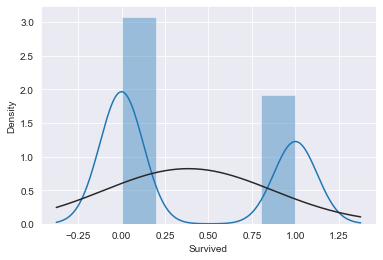

In [31]:
print(f"Dependent var'skew: {train.Survived.skew()}")
print(f"Dependent var'kurt: {train.Survived.kurt()}")

sns.distplot(train.Survived, fit=norm)
plt.show()

In [30]:
train.Survived.isnull().sum()

0

<h2 style='text-align:center;'>2. Search Independent Variable</h2>

In [33]:
all_data = pd.concat((train, test), axis=0).drop(['Survived'], axis=1)
all_data.shape

(1309, 11)

In [156]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

PassengerId: 제거 대상<br>
Survived: 종속변수<br>
Pclass: 순서형 변수<br>
Name: 제거대상<br>
Sex: 등간변수<br>
Age: 연속형변수<br>
SibSp: 등간변수<br>
Parch: 등간변수<br>
Ticket: 등간변수<br>
Fare: 연속형변수<br>
Cabin: 등간변수<br>
Embarked: 등간변수<br><br>
SibSp, Parch는 서로 비슷한 의미를 가지고 있는 변수이다. 카테고리 항목이 너무 많기 때문에 그대로 사용하면 원핫인코딩 결과에 의해 너무 많은 컬럼을 생성한다. 따라서 파생변수를 만들고 제거해주는 것이 좋을 것으로 보인다.<br><br>
Ticket은 등간형 변수지만 너무 많은 카테고리 항목을 보유하고 있다. 따라서 파생변수 생성 후 제거해주는 것이 좋을 것으로 보인다.<br><br>
Name은 Id와 비슷하게 큰 의미가 없기 때문에 제거 대상이 된다.

In [161]:
nominal_vars = [
    'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'
]

In [162]:
order_vars = [
    'Pclass'
]

In [163]:
continuous_vars = [
    'Age', 'Fare'
]

In [101]:
all_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


Fare가 0인 경우가 존재함.<br>

In [80]:
def best_continuous(var):
    print(f'skew: {all_data[var].skew()}')
    print(f'kurt: {all_data[var].kurt()}')
    f, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.distplot(all_data[var], fit=norm, ax=ax[0])
    probplot(all_data[var], plot=ax[1])
    plt.show()

skew: 0.40767455974362266
kurt: 0.1469476357378139


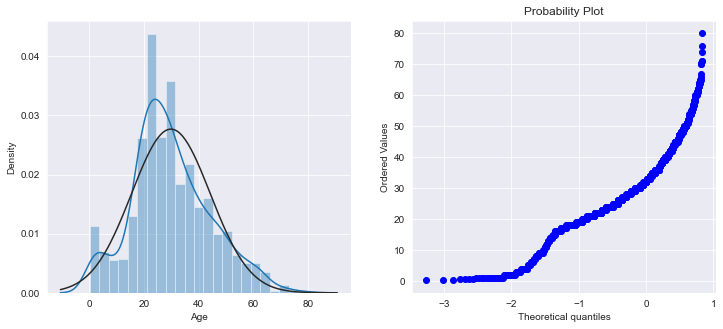

In [81]:
best_continuous('Age')

skew: 4.367709134122922
kurt: 27.027986349442294


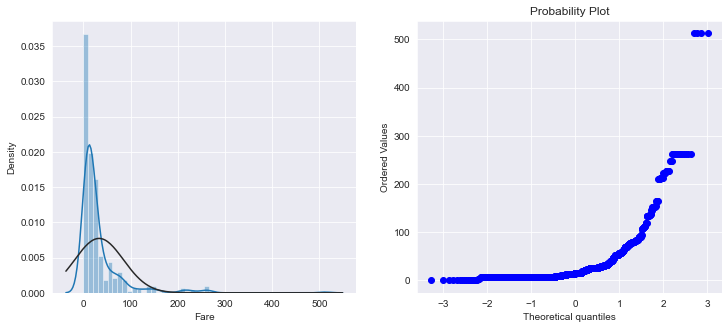

In [82]:
best_continuous('Fare')

연속형 변수들이 정규성을 만족하지 못하는 상태: 변수변환 필요.

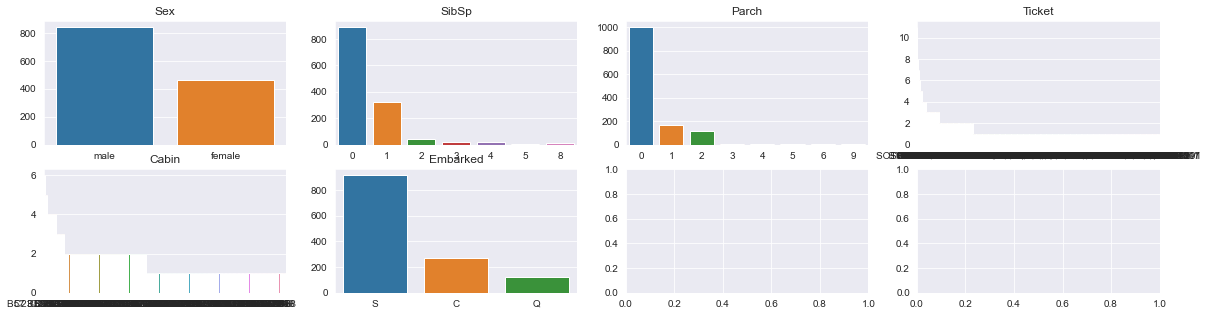

In [166]:
f, ax = plt.subplots(2, 4, figsize=(20, 5))
for i, c in enumerate(nominal_vars):
    g = sns.barplot(all_data[c].value_counts().index, all_data[c].value_counts().values, ax=ax[i//4][i%4])
    g.set_title(c)
plt.show()

범주형 변수들도 한쪽으로 치우쳐진 형태

In [110]:
miss_cnt = all_data.isnull().sum().sort_values(ascending=False)
miss_pct = miss_cnt / all_data.shape[0]
miss_table = pd.DataFrame([miss_cnt, miss_pct], index=['miss count', 'miss_percent']).T
miss_table = miss_table.loc[miss_table['miss count'] > 0]
miss_table

,miss count,miss_percent
Cabin,1014.0,0.774637
Age,263.0,0.200917
Embarked,2.0,0.001528
Fare,1.0,0.000764


<AxesSubplot:>

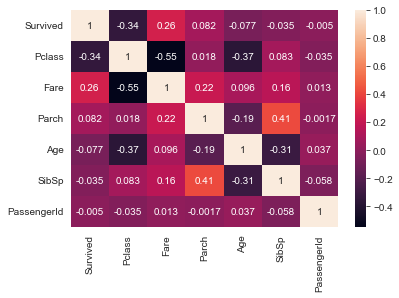

In [123]:
corrvars = abs(train.corr().Survived).sort_values(ascending=False).index
sns.heatmap(train[corrvars].corr(), annot=True)

<h1 style='text-align:center;'>Feature Engineering</h1>

<h2 style='text-align:center;'>1. Remove I / split train, test / merge all data</h2>

In [129]:
train_id = train.PassengerId
test_id = test.PassengerId
train_size = train.shape[0]
y_train = train.Survived
all_data = pd.concat((train, test), axis=0).drop(['Survived'], axis=1).reset_index(drop=True)

<h2 style='text-align:center;'>2. Cleansing - Missing Value</h2>

In [131]:
miss_table

,miss count,miss_percent
Cabin,1014.0,0.774637
Age,263.0,0.200917
Embarked,2.0,0.001528
Fare,1.0,0.000764


결측치를 제거해보자.<br><br>
<b>Cabin</b>은 cabin number를 의미한다. 상당한 양의 결측치를 가지고 있다. 나는 결측치를 대체할 수 있는 특정 값을 찾지 못했다. 이 변수는 결측치가 너무 많기 때문에 제거 대상이 된다. 하지만 곧바로 삭제하지 않고 파생변수 생성 후 제거한다.<br>
<b>Embarked</b>는 등간형 변수로, 소수의 결측치가 존재한다. 가장 무난한 방법은 최빈값 대체를 사용하는 것이다.<br>
<b>Age</b>: Age는 연속형 변수이다. 소수의 결측치가 존재한다. 가장 무난한 방법은 중앙값이나 평균값 대체를 사용하는 것이다. 나는 평균 + 분산 or 평균 - 분산 범위 내의 랜덤한 값으로 대체했다.<br>
<b>Fare</b>: Fare는 연속형 변수이다. 소수의 결측치가 존재한다. 가장 무난한 방법은 중앙값이나 평균값 대체를 사용하는 것이다. 나는 중앙값으로 대체했다.

In [190]:
all_data.Embarked = all_data.Embarked.fillna(all_data.Embarked.mode()[0])
all_data.Age.loc[all_data.Age.isnull()] = np.random.randint(all_data.Age.mean() - all_data.Age.std(),
                                                           all_data.Age.mean() + all_data.Age.std())
all_data.Fare = all_data.Fare.fillna(all_data.Fare.median())

<h2 style='text-align:center;'>3. 파생변수 생성</h2>

In [195]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [200]:
all_data['NameLength'] = all_data.Name.apply(len)
all_data['HasCabin'] = all_data.Cabin.apply(lambda x: 0 if type(x) == float else 1)
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['IsAlone'] = all_data['FamilySize'].apply(lambda x: 1 if x == 1 else 0)
all_data['CategoricalFare'] = pd.qcut(all_data.Fare, 4)
all_data['CategoricalAge'] = pd.cut(all_data.Age, 5)

all_data['Title'] = all_data['Name'].apply(get_title)
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')
all_data['Sex'] = all_data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
all_data['Title'] = all_data['Title'].map(title_mapping)
all_data['Title'] = all_data['Title'].fillna(0)
all_data['Embarked'] = all_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

all_data.loc[all_data['Fare'] <= 7.91, 'Fare'] = 0
all_data.loc[(all_data['Fare'] > 7.91) & (all_data['Fare'] <= 14.454), 'Fare'] = 1
all_data.loc[(all_data['Fare'] > 14.454) & (all_data['Fare'] <= 31), 'Fare'] = 2
all_data.loc[ all_data['Fare'] > 31, 'Fare'] = 3
all_data['Fare'] = all_data['Fare'].astype(int)

all_data.loc[all_data['Age'] <= 16, 'Age'] = 0
all_data.loc[(all_data['Age'] > 16) & (all_data['Age'] <= 32), 'Age'] = 1
all_data.loc[(all_data['Age'] > 32) & (all_data['Age'] <= 48), 'Age'] = 2
all_data.loc[(all_data['Age'] > 48) & (all_data['Age'] <= 64), 'Age'] = 3
all_data.loc[all_data['Age'] > 64, 'Age'] = 4

In [204]:
all_data.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,NameLength,HasCabin,FamilySize,IsAlone,Title
0,3,1,1.0,0,0,0,23,0,2,0,1
1,1,0,2.0,0,3,1,51,1,2,0,3
2,3,0,1.0,0,1,0,22,0,1,1,2
3,1,0,2.0,0,3,0,44,1,2,0,3
4,3,1,2.0,0,1,0,24,0,1,1,1


<h2 style='text-align:center;'>4. Select Variables</h2>

In [203]:
all_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'CategoricalAge', 'CategoricalFare'], axis=1, inplace=True)

<h1 style='text-align:center;'>Modeling</h1>

In [206]:
X_train = all_data.iloc[:train_size, :]
X_test = all_data.iloc[train_size:, :]